# Reference

This example is taken from [ML4A](http://ml4a.github.io) which is a great guide by G. Kogan. 

If you like to run the example locally follow the instructions provided on [Keras website](https://keras.io/#installation)

---

# Shortest path between images

This notebook demonstrates how, given a query of two images, to find a sequence of images between them whose visual changes are as gradual as possible.

The methodology is inspired by and (roughly) reverse-engineered from [X Degrees of Separation](https://artsexperiments.withgoogle.com/xdegrees/), a work by [Mario Klingemann](http://quasimondo.com/) and [Simon Doury](http://www.simondoury.com/) for [Google Arts & Culture Experiments](https://artsexperiments.withgoogle.com/). X Degrees of Separation finds smooth paths through images taken from museum collections. Mario gave me some hints to his strategy :) and I've made an approximate implementation here.

Some screenshots from their original work:

![X degrees 1](../assets/xdegrees1.png)

![X degrees 2](../assets/xdegrees2.png)


### Strategy

The approach to the problem is the following:

1) Analyze all images in your dataset, extracting a feature vector for each one from the pre-classification fully-connected layer of a trainedconvolutional neural network. This part is already done in the [image-search notebook](../notebooks/image-tsne.ipynb).

2) For each image, find its `k` nearest neighbors, i.e. the `k` neighboring images which have the smallest cosine distance from it.

3) Build a [graph](https://en.wikipedia.org/wiki/Graph_&#40;discrete_mathematics&#41;) whose vertices are the images and whose edges are the connections between nearest-neighbors found in step 2. 

4) At run-time, given a query of two images, find the shortest path through the graph between them, using the cosine distance as distance metric. That the vertices in the graph are not fully-connected ensures that it does not return the trivial direct path between the two endpoints.

The upside to this strategy is that it's relatively straightforward, easy to implement, and fast at run-time. The downside is that it doesn't guarantee that there is a path between any two images, since it is possible for some regions of the image space to become isolated from the larger grid if they are too self-similar. Additionally, for image sets which are unevenly distributed, the simple kNN threshold may produce very densely connected clusters. There are more sophisticated approaches which try to ensure that individual edges are not too long or too short, but for the sake of simplicity, we take the easier kNN approach.


### Installation and dependencies

The code for this notebook has a number of dependencies, which can usually be installed with `pip`. You will need:

 * [Pillow](https://python-pillow.org/)
 * [cPickle](https://docs.python.org/2/library/pickle.html)
 * [igraph](http://igraph.org/redirect.html)
 * [matplotlib](http://matplotlib.org)
 * [tqdm](https://pypi.python.org/pypi/tqdm)
 

### Get image features

This notebook assumes you have already extracted features for a directory of images and saved them to disk. If you haven't done this yet, see the previous notebook [reverse image search](image-search.ipynb), which shows you how to do this. Alternatively, you may [download the pre-analyzed vectors](https://drive.google.com/drive/folders/0B3WXSfqxKDkFYm9GMzlnemdEbEE?usp=sharing), along with the images from [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) by running:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
Or you can run the `download.sh` script in the `data` folder which will automatically download this dataset for you, along with all the other materials for these notebooks.
    
Now we can begin. Run the following import commands and make sure all the libraries are correctly installed and import without errors.

In [23]:
%matplotlib inline
import os
import random
import numpy as np
import pickle
import matplotlib.pyplot
from matplotlib.pyplot import imshow
from PIL import Image
from scipy.spatial import distance
from igraph import *
from tqdm import tqdm

Next, open your saved feature vectors with pickle, and ensure the images are in the correct paths.

In [24]:
images, pca_features = pickle.load(open('../data/features_yt_stock.p', 'rb'))

for i, f in  list(zip(images, pca_features))[:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

image: ../data/yt_stock/forest-lBmEoSYVhbw-009.jpg, features: 23.56,10.44,-22.10,33.70... 
image: ../data/yt_stock/tarsand-VhkgdrQceVM-001.jpg, features: 7.43,1.02,4.73,-12.66... 
image: ../data/yt_stock/moss-BF7V4Fuu4kE-002.jpg, features: 9.10,11.71,-0.16,-4.02... 
image: ../data/yt_stock/deforestation-M4jhjt1_eyM-001.jpg, features: -10.00,-21.60,-16.01,-3.21... 
image: ../data/yt_stock/tarsand-7kOkDIN4YD8-003.jpg, features: 3.20,-8.22,7.16,-10.53... 


The following cell is optional. If you wish to restrict your graph to a smaller set of images (perhaps for testing purposes), this cell will take a random subsample of your image set of size `num_images`. Set this number however you wish or skip the cell if you intend to use all the images.

In [25]:
num_images = 900

if len(images) > num_images:
    sort_order = sorted(random.sample(xrange(len(images)), num_images))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

Next, we are going to build our graph. The graph will contain one vertex for every image. The edges of the graph are found by taking the `k` nearest neighbor images to each image in the set, and adding an edge between them whose distance is given by cosine distance.

Here we set `kNN = 30` which means that we save 30 neighbor images. There are tradeoffs between lower and higher values of `kNN`. If `kNN` is very low, it helps to ensure that consecutive images in a path are as similar as possible, at the expense of making the paths longer in total nodes traversed, since low `kNN` restricts edges to a very small number of neighbors. However, there is increased risk that some regions are not connected to the rest of the graph and therefore unreachable in a query. If `kNN` is high, more nodes are connected to each other, and therefore paths will be shorter and more likely to exist, however there may be more visually dissimilar jumps between consecutive neighbors.

In [26]:
kNN = 20

graph = Graph(directed=True)
graph.add_vertices(len(images))

for i in tqdm(range(len(images))):
    distances = [ distance.cosine(pca_features[i], feat) for feat in pca_features ]
    if any( d < 0  for d in distances ):
        print('not ok')
    else:
        print('ok')
    
    idx_kNN = sorted(range(len(distances)), key=lambda k: distances[k])[1:kNN+1]
    for j in idx_kNN:
        graph.add_edge(i, j, weight=distances[j])
    
summary(graph)

  1%|          | 6/900 [00:00<00:32, 27.39it/s]

ok
ok
ok
ok
ok
ok
ok


  1%|▏         | 12/900 [00:00<00:31, 27.82it/s]

ok
ok
ok
ok
ok
ok


  2%|▏         | 18/900 [00:00<00:32, 27.04it/s]

ok
ok
ok
ok
ok
ok
ok


  3%|▎         | 24/900 [00:00<00:32, 27.12it/s]

ok
ok
ok
ok
ok
ok


  3%|▎         | 30/900 [00:01<00:32, 26.57it/s]

ok
ok
ok
ok
ok


  4%|▍         | 36/900 [00:01<00:32, 26.27it/s]

ok
ok
ok
ok
ok
ok


  5%|▍         | 42/900 [00:01<00:33, 25.89it/s]

ok
ok
ok
ok
ok
ok


  5%|▌         | 48/900 [00:01<00:32, 26.01it/s]

ok
ok
ok
ok
ok
ok


  6%|▌         | 54/900 [00:02<00:32, 26.10it/s]

ok
ok
ok
ok
ok
ok


  7%|▋         | 60/900 [00:02<00:32, 26.16it/s]

ok
ok
ok
ok
ok
ok


  7%|▋         | 66/900 [00:02<00:31, 26.12it/s]

ok
ok
ok
ok
ok
ok


  8%|▊         | 72/900 [00:02<00:31, 26.01it/s]

ok
ok
ok
ok
ok
ok


  9%|▊         | 78/900 [00:03<00:31, 25.91it/s]

ok
ok
ok
ok
ok
ok


  9%|▉         | 84/900 [00:03<00:32, 25.48it/s]

ok
ok
ok
ok
ok


 10%|█         | 90/900 [00:03<00:31, 25.46it/s]

ok
ok
ok
ok
ok
ok


 10%|█         | 93/900 [00:03<00:31, 25.47it/s]

ok
ok
ok
ok
ok


 11%|█         | 99/900 [00:03<00:31, 25.10it/s]

ok
ok
ok
ok
ok


 12%|█▏        | 105/900 [00:04<00:31, 25.00it/s]

ok
ok
ok
ok
ok
ok


 12%|█▏        | 111/900 [00:04<00:31, 24.80it/s]

ok
ok
ok
ok
ok


 13%|█▎        | 117/900 [00:04<00:31, 24.75it/s]

ok
ok
ok
ok
ok
ok


 14%|█▎        | 123/900 [00:04<00:31, 24.62it/s]

ok
ok
ok
ok
ok
ok


 14%|█▍        | 129/900 [00:05<00:31, 24.60it/s]

ok
ok
ok
ok
ok
ok
ok


 15%|█▌        | 135/900 [00:05<00:31, 24.61it/s]

ok
ok
ok
ok
ok


 16%|█▌        | 141/900 [00:05<00:30, 24.58it/s]

ok
ok
ok
ok
ok
ok


 16%|█▋        | 147/900 [00:05<00:30, 24.55it/s]

ok
ok
ok
ok
ok
ok
ok


 17%|█▋        | 153/900 [00:06<00:30, 24.51it/s]

ok
ok
ok
ok
ok
ok


 18%|█▊        | 159/900 [00:06<00:30, 24.46it/s]

ok
ok
ok
ok
ok


 18%|█▊        | 162/900 [00:06<00:30, 24.45it/s]

ok
ok
ok
ok
ok
ok


 19%|█▊        | 168/900 [00:06<00:29, 24.40it/s]

ok
ok
ok
ok
ok


 19%|█▉        | 174/900 [00:07<00:29, 24.34it/s]

ok
ok
ok
ok
ok


 20%|██        | 180/900 [00:07<00:29, 24.27it/s]

ok
ok
ok
ok
ok
ok


 21%|██        | 186/900 [00:07<00:29, 24.23it/s]

ok
ok
ok
ok
ok
ok


 21%|██▏       | 192/900 [00:07<00:29, 24.21it/s]

ok
ok
ok
ok
ok


 22%|██▏       | 198/900 [00:08<00:29, 24.16it/s]

ok
ok
ok
ok
ok
ok


 22%|██▏       | 201/900 [00:08<00:28, 24.13it/s]

ok
ok
ok
ok
ok


 23%|██▎       | 207/900 [00:08<00:28, 24.09it/s]

ok
ok
ok
ok
ok


 24%|██▎       | 213/900 [00:08<00:28, 24.06it/s]

ok
ok
ok
ok
ok
ok


 24%|██▍       | 219/900 [00:09<00:28, 24.06it/s]

ok
ok
ok
ok
ok
ok


 25%|██▌       | 225/900 [00:09<00:28, 24.02it/s]

ok
ok
ok
ok
ok


 25%|██▌       | 228/900 [00:09<00:27, 24.00it/s]

ok
ok
ok
ok
ok


 26%|██▌       | 234/900 [00:09<00:27, 24.00it/s]

ok
ok
ok
ok
ok
ok


 27%|██▋       | 240/900 [00:10<00:27, 23.99it/s]

ok
ok
ok
ok
ok


 27%|██▋       | 246/900 [00:10<00:27, 23.95it/s]

ok
ok
ok
ok
ok


 28%|██▊       | 249/900 [00:10<00:27, 23.93it/s]

ok
ok
ok
ok
ok


 28%|██▊       | 255/900 [00:10<00:26, 23.92it/s]

ok
ok
ok
ok
ok


 29%|██▉       | 261/900 [00:10<00:26, 23.87it/s]

ok
ok
ok
ok
ok


 29%|██▉       | 264/900 [00:11<00:26, 23.84it/s]

ok
ok
ok
ok
ok


 30%|███       | 270/900 [00:11<00:26, 23.81it/s]

ok
ok
ok
ok
ok


 31%|███       | 276/900 [00:11<00:26, 23.74it/s]

ok
ok
ok
ok
ok


 31%|███▏      | 282/900 [00:11<00:26, 23.72it/s]

ok
ok
ok
ok
ok
ok


 32%|███▏      | 285/900 [00:12<00:25, 23.70it/s]

ok
ok
ok
ok
ok


 32%|███▏      | 291/900 [00:12<00:25, 23.66it/s]

ok
ok
ok
ok
ok


 33%|███▎      | 297/900 [00:12<00:25, 23.60it/s]

ok
ok
ok
ok
ok
ok


 34%|███▎      | 303/900 [00:12<00:25, 23.56it/s]

ok
ok
ok
ok
ok


 34%|███▍      | 306/900 [00:13<00:25, 23.53it/s]

ok
ok
ok
ok
ok


 35%|███▍      | 312/900 [00:13<00:25, 23.48it/s]

ok
ok
ok
ok
ok


 35%|███▌      | 318/900 [00:13<00:24, 23.45it/s]

ok
ok
ok
ok
ok


 36%|███▌      | 321/900 [00:13<00:24, 23.44it/s]

ok
ok
ok
ok
ok


 36%|███▋      | 327/900 [00:13<00:24, 23.42it/s]

ok
ok
ok
ok
ok


 37%|███▋      | 333/900 [00:14<00:24, 23.41it/s]

ok
ok
ok
ok
ok


 37%|███▋      | 336/900 [00:14<00:24, 23.39it/s]

ok
ok
ok
ok
ok


 38%|███▊      | 342/900 [00:14<00:23, 23.37it/s]

ok
ok
ok
ok
ok


 39%|███▊      | 348/900 [00:14<00:23, 23.35it/s]

ok
ok
ok
ok
ok


 39%|███▉      | 351/900 [00:15<00:23, 23.34it/s]

ok
ok
ok
ok
ok


 40%|███▉      | 357/900 [00:15<00:23, 23.30it/s]

ok
ok
ok
ok
ok


 40%|████      | 363/900 [00:15<00:23, 23.25it/s]

ok
ok
ok
ok
ok


 41%|████      | 366/900 [00:15<00:22, 23.23it/s]

ok
ok
ok
ok
ok


 41%|████▏     | 372/900 [00:16<00:22, 23.20it/s]

ok
ok
ok
ok
ok


 42%|████▏     | 378/900 [00:16<00:22, 23.16it/s]

ok
ok
ok
ok
ok


 42%|████▏     | 381/900 [00:16<00:22, 23.14it/s]

ok
ok
ok
ok
ok


 43%|████▎     | 387/900 [00:16<00:22, 23.08it/s]

ok
ok
ok
ok
ok


 44%|████▎     | 393/900 [00:17<00:21, 23.05it/s]

ok
ok
ok
ok
ok


 44%|████▍     | 396/900 [00:17<00:21, 23.02it/s]

ok
ok
ok
ok
ok


 45%|████▍     | 402/900 [00:17<00:21, 22.97it/s]

ok
ok
ok
ok
ok


 45%|████▌     | 408/900 [00:17<00:21, 22.95it/s]

ok
ok
ok
ok
ok


 46%|████▌     | 411/900 [00:17<00:21, 22.94it/s]

ok
ok
ok
ok
ok


 46%|████▋     | 417/900 [00:18<00:21, 22.90it/s]

ok
ok
ok
ok
ok


 47%|████▋     | 423/900 [00:18<00:20, 22.86it/s]

ok
ok
ok
ok
ok
ok


 48%|████▊     | 429/900 [00:18<00:20, 22.84it/s]

ok
ok
ok
ok
ok


 48%|████▊     | 432/900 [00:18<00:20, 22.83it/s]

ok
ok
ok
ok
ok
ok


 49%|████▊     | 438/900 [00:19<00:20, 22.82it/s]

ok
ok
ok
ok
ok


 49%|████▉     | 444/900 [00:19<00:20, 22.77it/s]

ok
ok
ok
ok
ok


 50%|█████     | 450/900 [00:19<00:19, 22.74it/s]

ok
ok
ok
ok
ok


 50%|█████     | 453/900 [00:19<00:19, 22.73it/s]

ok
ok
ok
ok
ok


 51%|█████     | 459/900 [00:20<00:19, 22.70it/s]

ok
ok
ok
ok
ok


 52%|█████▏    | 465/900 [00:20<00:19, 22.68it/s]

ok
ok
ok
ok
ok
ok


 52%|█████▏    | 471/900 [00:20<00:18, 22.66it/s]

ok
ok
ok
ok
ok


 53%|█████▎    | 474/900 [00:20<00:18, 22.65it/s]

ok
ok
ok
ok
ok


 53%|█████▎    | 480/900 [00:21<00:18, 22.61it/s]

ok
ok
ok
ok
ok


 54%|█████▍    | 486/900 [00:21<00:18, 22.59it/s]

ok
ok
ok
ok
ok


 54%|█████▍    | 489/900 [00:21<00:18, 22.58it/s]

ok
ok
ok
ok
ok


 55%|█████▌    | 495/900 [00:21<00:17, 22.56it/s]

ok
ok
ok
ok
ok


 56%|█████▌    | 501/900 [00:22<00:17, 22.53it/s]

ok
ok
ok
ok
ok


 56%|█████▌    | 504/900 [00:22<00:17, 22.52it/s]

ok
ok
ok
ok
ok


 57%|█████▋    | 510/900 [00:22<00:17, 22.50it/s]

ok
ok
ok
ok
ok


 57%|█████▋    | 516/900 [00:22<00:17, 22.47it/s]

ok
ok
ok
ok
ok


 58%|█████▊    | 519/900 [00:23<00:16, 22.46it/s]

ok
ok
ok
ok
ok


 58%|█████▊    | 525/900 [00:23<00:16, 22.43it/s]

ok
ok
ok
ok
ok


 59%|█████▊    | 528/900 [00:23<00:16, 22.41it/s]

ok
ok
ok
ok
ok


 59%|█████▉    | 534/900 [00:23<00:16, 22.39it/s]

ok
ok
ok
ok
ok


 60%|██████    | 540/900 [00:24<00:16, 22.37it/s]

ok
ok
ok
ok
ok


 60%|██████    | 543/900 [00:24<00:15, 22.35it/s]

ok
ok
ok
ok
ok


 61%|██████    | 549/900 [00:24<00:15, 22.32it/s]

ok
ok
ok
ok
ok


 62%|██████▏   | 556/900 [00:24<00:15, 22.28it/s]

ok
ok
ok
ok
ok


 62%|██████▏   | 558/900 [00:25<00:15, 22.27it/s]

ok
ok
ok
ok
ok


 63%|██████▎   | 565/900 [00:25<00:15, 22.24it/s]

ok
ok
ok
ok
ok


 63%|██████▎   | 569/900 [00:25<00:14, 22.22it/s]

ok
ok
ok
ok
ok


 64%|██████▎   | 573/900 [00:25<00:14, 22.19it/s]

ok
ok
ok
ok
ok


 64%|██████▍   | 580/900 [00:26<00:14, 22.16it/s]

ok
ok
ok
ok
ok


 65%|██████▍   | 584/900 [00:26<00:14, 22.13it/s]

ok
ok
ok
ok


 65%|██████▌   | 588/900 [00:26<00:14, 22.11it/s]

ok
ok
ok
ok
ok


 66%|██████▌   | 594/900 [00:26<00:13, 22.07it/s]

ok
ok
ok
ok


 66%|██████▋   | 598/900 [00:27<00:13, 22.04it/s]

ok
ok
ok
ok
ok


 67%|██████▋   | 602/900 [00:27<00:13, 22.02it/s]

ok
ok
ok
ok


 67%|██████▋   | 606/900 [00:27<00:13, 21.99it/s]

ok
ok
ok
ok


 68%|██████▊   | 610/900 [00:27<00:13, 21.96it/s]

ok
ok
ok
ok


 68%|██████▊   | 614/900 [00:28<00:13, 21.92it/s]

ok
ok
ok
ok


 69%|██████▊   | 618/900 [00:28<00:12, 21.89it/s]

ok
ok
ok
ok


 69%|██████▉   | 622/900 [00:28<00:12, 21.86it/s]

ok
ok
ok
ok


 70%|██████▉   | 626/900 [00:28<00:12, 21.82it/s]

ok
ok
ok
ok


 70%|███████   | 630/900 [00:28<00:12, 21.78it/s]

ok
ok
ok
ok


 70%|███████   | 634/900 [00:29<00:12, 21.75it/s]

ok
ok
ok
ok


 71%|███████   | 640/900 [00:29<00:11, 21.71it/s]

ok
ok
ok
ok
ok


 72%|███████▏  | 644/900 [00:29<00:11, 21.68it/s]

ok
ok
ok
ok


 72%|███████▏  | 648/900 [00:29<00:11, 21.63it/s]

ok
ok
ok
ok


 72%|███████▏  | 652/900 [00:30<00:11, 21.61it/s]

ok
ok
ok
ok
ok


 73%|███████▎  | 656/900 [00:30<00:11, 21.59it/s]

ok
ok
ok
ok


 73%|███████▎  | 660/900 [00:30<00:11, 21.57it/s]

ok
ok
ok
ok
ok


 74%|███████▍  | 666/900 [00:30<00:10, 21.53it/s]

ok
ok
ok
ok


 74%|███████▍  | 670/900 [00:31<00:10, 21.49it/s]

ok
ok
ok
ok


 75%|███████▍  | 674/900 [00:31<00:10, 21.46it/s]

ok
ok
ok
ok


 75%|███████▌  | 678/900 [00:31<00:10, 21.44it/s]

ok
ok
ok
ok
ok


 76%|███████▌  | 682/900 [00:31<00:10, 21.42it/s]

ok
ok
ok
ok


 76%|███████▌  | 686/900 [00:32<00:10, 21.39it/s]

ok
ok
ok
ok


 77%|███████▋  | 690/900 [00:32<00:09, 21.35it/s]

ok
ok
ok
ok


 77%|███████▋  | 694/900 [00:32<00:09, 21.31it/s]

ok
ok
ok
ok


 78%|███████▊  | 698/900 [00:32<00:09, 21.28it/s]

ok
ok
ok
ok


 78%|███████▊  | 702/900 [00:33<00:09, 21.26it/s]

ok
ok
ok
ok


 78%|███████▊  | 706/900 [00:33<00:09, 21.23it/s]

ok
ok
ok
ok


 79%|███████▉  | 710/900 [00:33<00:08, 21.19it/s]

ok
ok
ok
ok


 79%|███████▉  | 714/900 [00:33<00:08, 21.15it/s]

ok
ok
ok
ok


 80%|███████▉  | 718/900 [00:33<00:08, 21.13it/s]

ok
ok
ok
ok


 80%|████████  | 722/900 [00:34<00:08, 21.09it/s]

ok
ok
ok
ok


 81%|████████  | 726/900 [00:34<00:08, 21.06it/s]

ok
ok
ok
ok


 81%|████████  | 730/900 [00:34<00:08, 21.02it/s]

ok
ok
ok
ok


 82%|████████▏ | 734/900 [00:34<00:07, 20.99it/s]

ok
ok
ok
ok


 82%|████████▏ | 738/900 [00:35<00:07, 20.96it/s]

ok
ok
ok
ok


 82%|████████▏ | 742/900 [00:35<00:07, 20.94it/s]

ok
ok
ok
ok


 83%|████████▎ | 746/900 [00:35<00:07, 20.91it/s]

ok
ok
ok
ok


 83%|████████▎ | 750/900 [00:35<00:07, 20.88it/s]

ok
ok
ok
ok


 84%|████████▍ | 754/900 [00:36<00:07, 20.86it/s]

ok
ok
ok
ok


 84%|████████▍ | 758/900 [00:36<00:06, 20.84it/s]

ok
ok
ok
ok


 85%|████████▍ | 762/900 [00:36<00:06, 20.81it/s]

ok
ok
ok
ok


 85%|████████▌ | 766/900 [00:36<00:06, 20.80it/s]

ok
ok
ok
ok


 86%|████████▌ | 770/900 [00:37<00:06, 20.77it/s]

ok
ok
ok
ok


 86%|████████▌ | 774/900 [00:37<00:06, 20.74it/s]

ok
ok
ok
ok


 86%|████████▋ | 778/900 [00:37<00:05, 20.71it/s]

ok
ok
ok
ok


 87%|████████▋ | 782/900 [00:37<00:05, 20.69it/s]

ok
ok
ok
ok


 87%|████████▋ | 786/900 [00:38<00:05, 20.66it/s]

ok
ok
ok
ok


 88%|████████▊ | 790/900 [00:38<00:05, 20.63it/s]

ok
ok
ok
ok


 88%|████████▊ | 794/900 [00:38<00:05, 20.61it/s]

ok
ok
ok
ok


 89%|████████▊ | 798/900 [00:38<00:04, 20.59it/s]

ok
ok
ok
ok


 89%|████████▉ | 802/900 [00:38<00:04, 20.57it/s]

ok
ok
ok
ok


 90%|████████▉ | 806/900 [00:39<00:04, 20.55it/s]

ok
ok
ok
ok


 90%|█████████ | 810/900 [00:39<00:04, 20.53it/s]

ok
ok
ok
ok


 90%|█████████ | 814/900 [00:39<00:04, 20.51it/s]

ok
ok
ok
ok


 91%|█████████ | 818/900 [00:39<00:04, 20.49it/s]

ok
ok
ok
ok


 91%|█████████▏| 822/900 [00:40<00:03, 20.47it/s]

ok
ok
ok
ok


 92%|█████████▏| 826/900 [00:40<00:03, 20.45it/s]

ok
ok
ok
ok


 92%|█████████▏| 830/900 [00:40<00:03, 20.43it/s]

ok
ok
ok
ok


 93%|█████████▎| 834/900 [00:40<00:03, 20.41it/s]

ok
ok
ok
ok


 93%|█████████▎| 838/900 [00:41<00:03, 20.39it/s]

ok
ok
ok
ok


 94%|█████████▎| 842/900 [00:41<00:02, 20.36it/s]

ok
ok
ok
ok


 94%|█████████▍| 846/900 [00:41<00:02, 20.35it/s]

ok
ok
ok
ok


 94%|█████████▍| 850/900 [00:41<00:02, 20.32it/s]

ok
ok
ok
ok


 95%|█████████▍| 854/900 [00:42<00:02, 20.31it/s]

ok
ok
ok
ok


 95%|█████████▌| 858/900 [00:42<00:02, 20.29it/s]

ok
ok
ok
ok


 96%|█████████▌| 862/900 [00:42<00:01, 20.27it/s]

ok
ok
ok
ok


 96%|█████████▌| 866/900 [00:42<00:01, 20.25it/s]

ok
ok
ok
ok


 97%|█████████▋| 870/900 [00:43<00:01, 20.22it/s]

ok
ok
ok
ok


 97%|█████████▋| 874/900 [00:43<00:01, 20.20it/s]

ok
ok
ok
ok


 98%|█████████▊| 878/900 [00:43<00:01, 20.17it/s]

ok
ok
ok
ok


 98%|█████████▊| 882/900 [00:43<00:00, 20.14it/s]

ok
ok
ok
ok


 98%|█████████▊| 886/900 [00:44<00:00, 20.11it/s]

ok
ok
ok
ok


 99%|█████████▉| 890/900 [00:44<00:00, 20.10it/s]

ok
ok
ok
ok


 99%|█████████▉| 894/900 [00:44<00:00, 20.08it/s]

ok
ok
ok
ok


100%|█████████▉| 898/900 [00:44<00:00, 20.06it/s]

ok
ok
ok
ok


100%|██████████| 900/900 [00:44<00:00, 20.05it/s]

ok
IGRAPH D-W- 900 18000 -- 
+ attr: weight (e)


Once the graph has been saved, we can save it along with the image paths to disk, so we can load them and use them later.

In [14]:
# pickle.dump([images, graph], open('../data/graph_caltech101_30knn.p', 'wb'))

Later, we can retrieve them in the following way (uncomment the following line).

In [18]:
images, graph = pickle.load(open('../data/graph_caltech101_30knn.p', 'rb'))

For the sake of convenience, we define a helper function which will concatenate a sequence of images into a single image so we can display the sequences in this notebook. The helper function takes a `thumb_height` and resizes all the images so they have that as their height.

In [19]:
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = Image.open(images[idx])
        img = img.convert('RGB')
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Now we can do a query. We'll just pick two random indices (`idx1` and `idx2`) and run `igraph`'s `get_shortest_paths` method, using the cosine distance ('weight' as the `weights`).

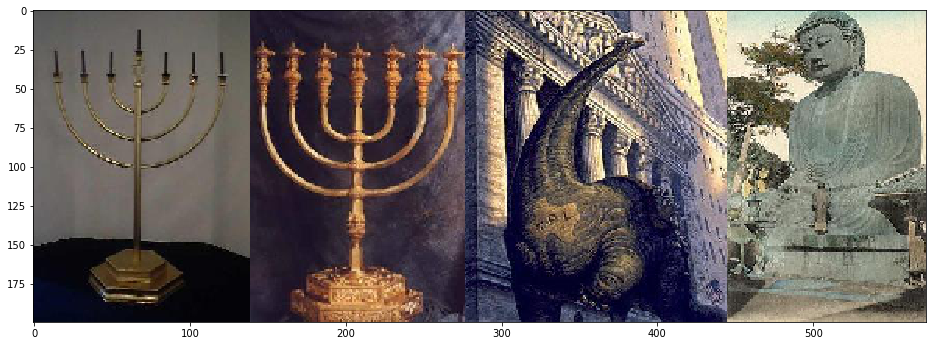

In [22]:
# pick two random indices
idx1 = int(len(images) * random.random())
idx2 = int(len(images) * random.random())

# run get_shortest_paths
path = graph.get_shortest_paths(idx1, to=idx2, mode=OUT, output='vpath', weights='weight')[0]

# retrieve the images, concatenate into one, and display them
results_image = get_concatenated_images(path, 200)
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)

Not too bad! Let's try again...

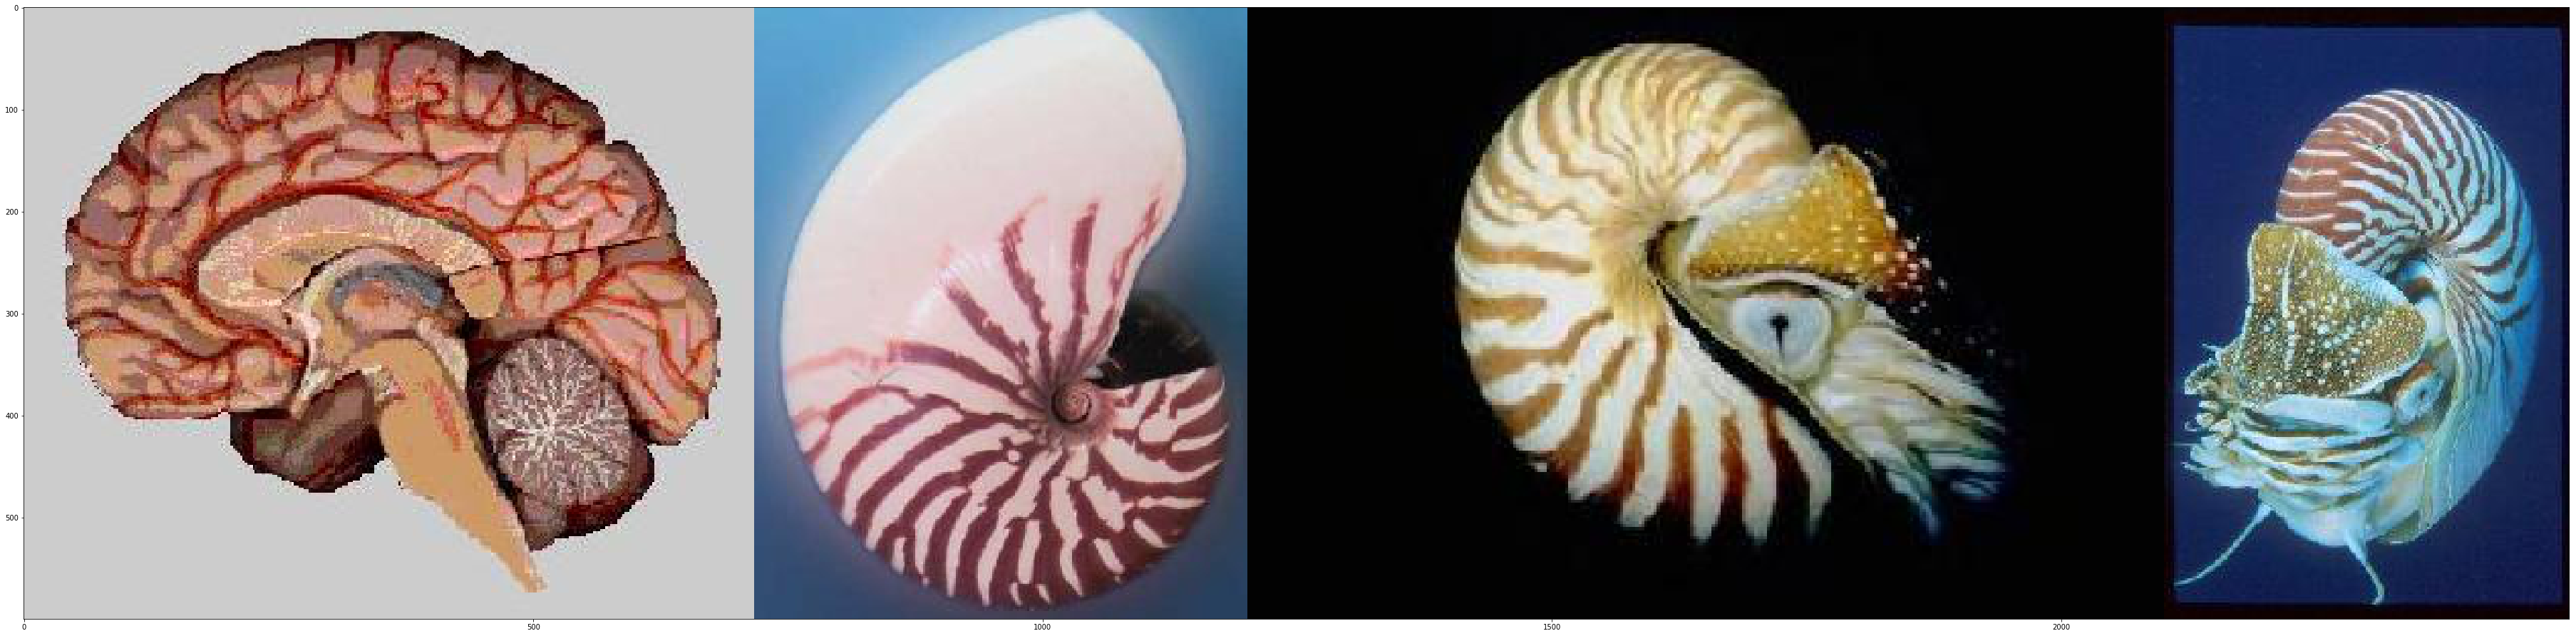

In [11]:
# pick two random indices
idx1 = int(len(images) * random.random())
idx2 = int(len(images) * random.random())

# run get_shortest_paths
path = graph.get_shortest_paths(idx1, to=idx2, mode=OUT, output='vpath', weights='weight')[0]

# retrieve the images, concatenate into one, and display them
results_image = get_concatenated_images(path, 600)
matplotlib.pyplot.figure(figsize = (64,48))
imshow(results_image) 

Depending on how low you set your `kNN` you may have occasional errors where a path cannot be found between two isolated nodes. But with `kNN>=30` this appears to be a rare event.

Not all paths are going to be very interesting. This depends greatly on the character of your image set. Some image sets (like CalTech-101 or CalTech-256) are very highly clustered around object categories, which means there may not always be good candidates between two image classes. Datasets which have more variety tend to work better for this reason.

Here are some examples of paths found in CalTech-101:

![X degrees samples](../assets/xdegrees_samples.jpg)